# Transformations for 3D medical images

In [ ]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [ ]:
# export
# default_exp augment
from fastai.torch_basics import *
from fastai.basics import *
from fastai.vision.augment import *
import torchvision.transforms.functional as _F
import torchvision

In [ ]:
# export
from faimed3d.basics import *

## Resizing

In [ ]:
# export

@patch
def resize_3d(t: (TensorDicom3D, TensorMask3D), size, scale_factor=None, 
              mode='trilinear', align_corners=True, recompute_scale_factor=None):
    '''
    A function to resize a 3D image using torch.nn.functional.interpolate
    
    Args:
        t (Tensor): a 3D or 4D Tensor to be resized
        size (int): a tuple with the new x,y,z dimensions of the tensor after resize
        scale_factor, mode, align_corners, recompute_scale_factor: args from F.interpolate
    Returns: 
        A new `Tensor` with Tensor.size = size
    '''
    if isinstance(t, TensorMask3D): 
        t = t.long()
        resize_fun=index_based_resize
    else: 
        resize_fun=partial(F.interpolate, 
                           scale_factor=scale_factor,
                           mode=mode, 
                           align_corners=align_corners,
                           recompute_scale_factor=recompute_scale_factor)
        
    if t.ndim == 3: t=t.unsqueeze(0)   # add fake chanel dim
    if t.ndim == 4: t=t.unsqueeze(0)   # add fake batch dim
   
    return resize_fun(t, size=size).squeeze() #remove fake dims

def index_based_resize(t: TensorMask3D, size: int):
    "resizes a Tensor without creating new values"
    N, C, D, H, W = t.size()
    d, h, w = size
    id = torch.linspace(0, D-1, d).long()
    iw = torch.linspace(0, W-1, w).long()
    ih = torch.linspace(0, H-1, h).long()
    x_interp = t[:, :, :, ih[:, None], iw]
    return x_interp[:, :, id, :, :].float()
    

class Resize3D(RandTransform):
    split_idx,order = None, 1
    "Resize a 3D image"
    
    def __init__(self, size, scale_factor=None, mode='trilinear', align_corners=True, recompute_scale_factor=None, **kwargs): 
        store_attr()
        self.size = _process_sz_3d(self.size)
        super().__init__(**kwargs)

    def encodes(self, x: (TensorDicom3D)): 
        dev=x.device
        x = x.resize_3d(self.size, self.scale_factor, self.mode, self.align_corners, self.recompute_scale_factor)
        return x.to(dev)  

    def encodes(self, x: (TensorMask3D)): 
        dev=x.device
        x = x.resize_3d(self.size, self.scale_factor, 'nearest', self.align_corners, self.recompute_scale_factor)
        return x.to(dev)
    
def _process_sz_3d(size):
    if len(size) == 2: size=(size[0],size[1], size[1])
    return fastuple(size[0],size[1],size[2])       

In [ ]:
original = TensorDicom3D.create('../data/series/radiopaedia_10_85902_1.nii.gz')
mask = TensorMask3D.create('../data/masks/radiopaedia_10_85902_1.nii.gz')

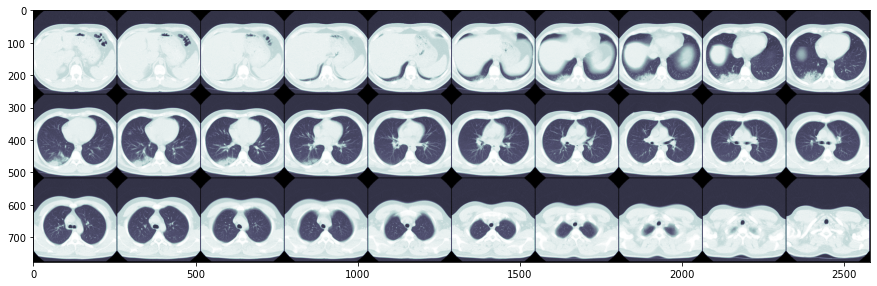

In [ ]:
original.show()

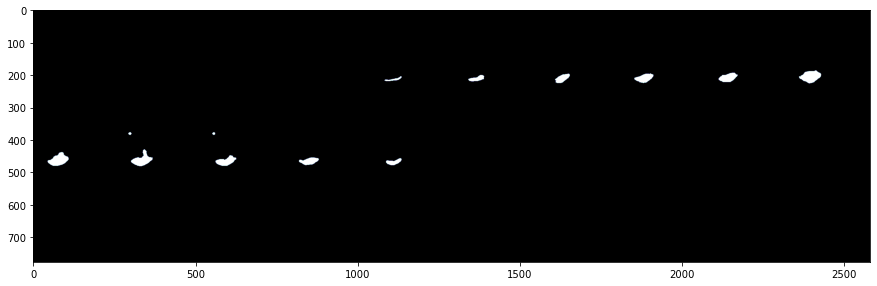

In [ ]:
mask.show()

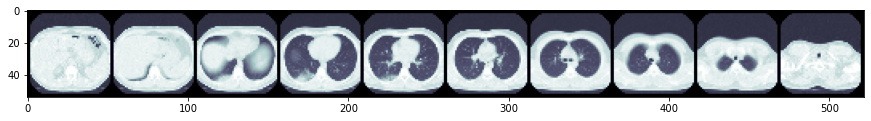

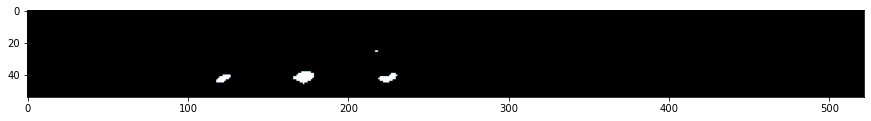

In [ ]:
Resize3D((10,50,50))(original, split_idx = 0).show()
Resize3D((10,50,50))(mask, split_idx = 0).show()

## Padding
Change size of tensor without changing size of the raw pixel data

In [ ]:
#export 
@patch
def pad_to(im:(TensorDicom3D, TensorMask3D), new_size:tuple):
    pad = [((x-y) // 2,)*2 for x,y, in zip(new_size, im.size())]
    pad =[item for t in pad for item in t] 
    pad.reverse()
    im = F.pad(im, pad)
    return im.resize_3d(new_size) if im.size() != new_size else im

class Pad3D(RandTransform):
    split_idx,order = None, 1
    "Resize and crop a 3D tensor"

    def __init__(self, new_size, p=1, **kwargs):
        store_attr()
        super().__init__(p=p,**kwargs)

    def encodes(self, x:(TensorDicom3D,TensorMask3D)):
        return x.pad_to(self.new_size)

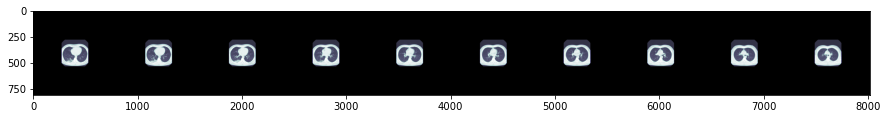

In [ ]:
Pad3D((10, 800, 800))(original).show()

## Flipping

In medical images, the left and right side often cannot be differentiated from each other (e.g. scans of the head, hand, knee, ...). Therfore the image orientation is stored in the image header, enabeling the viewer system to accuratly display the images. 
For deep learning, only the pixel array is extracted, so the header information is lost. When displaying only the pixel array, the images might already be displayed flipped or in inverted slice order. So, implementing vertical/horizontal flipping as well as flipping alongside the z axis can be used for data augmentation.  

In [ ]:
# export

@patch
def flip_ll_3d(t: (TensorDicom3D, TensorMask3D)): 
    "flips an image laterolateral"
    return t.flip(-1) # works on 3D images and 4D batchs

@patch
def flip_ap_3d(t: (TensorDicom3D, TensorMask3D)):
    "flips an image anterior posterior"
    return t.flip(-2)

@patch
def flip_cc_3d(t: (TensorDicom3D, TensorMask3D)):
    "flips an image cranio caudal"
    return t.flip(-3)


In [ ]:
# export

class RandomFlip3D(RandTransform):
    "Randomly flip alongside any axis with probability `p`"
    def __init__(self, p=0.75): 
        super().__init__(p=p)
        
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.axis = random.randint(1, 3)*-1  # add a random integer for axis to rotate
        
    def encodes(self, x:(TensorDicom3D, TensorMask3D)): 
        return x.flip(self.axis)

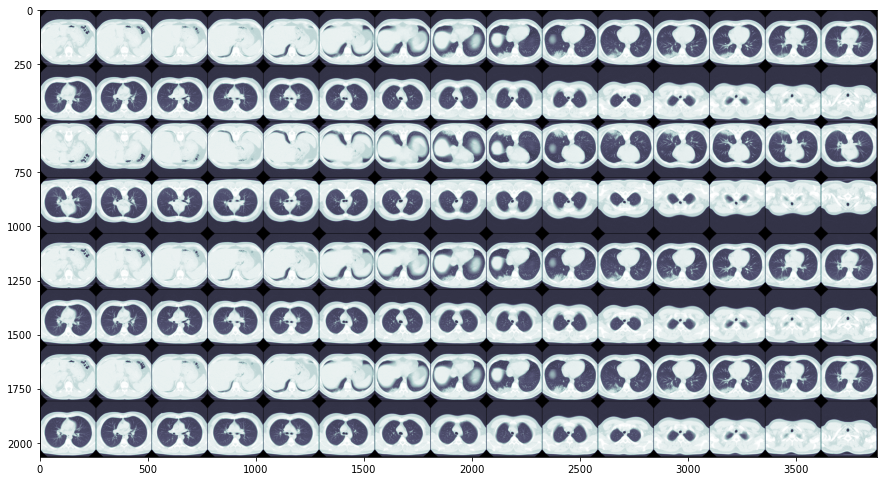

In [ ]:
torch.stack((original, RandomFlip3D()(original, split_idx = 0), 
                       RandomFlip3D()(original, split_idx = 0), 
                       RandomFlip3D()(original, split_idx = 0))).show(nrow = 15)

## Rotating
Medical images should show no rotation, however with removal of the image file header, the pixel array might appear rotated when displayed and thus be introduced to the model rotated. Fruthermore, in some images the patients might be rotated to some degree. Thus rotation of 90 and 180° as well as substeps should be implemented. 

In [ ]:
# export

@patch 
def rotate_90_3d(t: (TensorDicom3D, TensorMask3D)):
    return t.transpose(1, 2) if t.ndim == 3 else t.transpose(2, 3) 

@patch
def rotate_270_3d(t: (TensorDicom3D, TensorMask3D)):
    return t.transpose(1, 2).flip(-1) if t.ndim == 3 else t.transpose(2, 3).flip(-1)

@patch
def rotate_180_3d(t: (TensorDicom3D, TensorMask3D)):
    return t.flip(-1).flip(-2)        


class RandomRotate3D(RandTransform):
    "Randomly flip rotates the axial slices of the 3D image 90/180 or 270 degrees with probability `p`"
    def __init__(self, p=0.5): 
        super().__init__(p=p)
    
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.which = random.randint(1, 3)  # add a random integer for axis to rotate
        
    def encodes(self, x:(TensorDicom3D, TensorMask3D)): 
        if self.which == 1: x = x.rotate_90_3d()
        elif self.which == 2: x = x.rotate_180_3d()
        else: x = x.rotate_270_3d()
        return x 

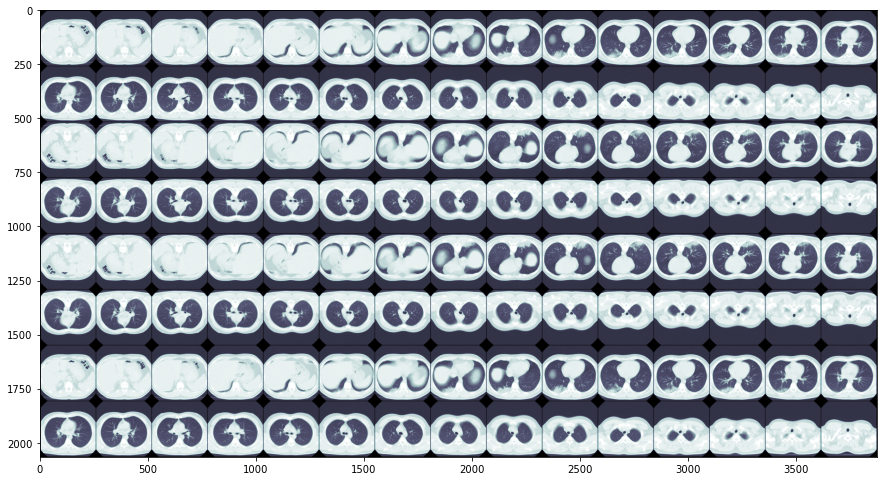

In [ ]:
torch.stack((original, RandomRotate3D()(original, split_idx = 0),  
             RandomRotate3D()(original, split_idx = 0),  RandomRotate3D()(original, split_idx = 0))).show(nrow = 15)

Pytorch does not support rotation of 3D images, so some transformations need to be applied slicewise. 

In [ ]:
# export
@patch
def apply_along_dim(t:(TensorDicom3D, TensorMask3D), func, dim):
    img_slices = torch.unbind(t, dim)
    return torch.stack([func(img_slice) for img_slice in img_slices], dim)

In [ ]:
# export
class RandomRotate3DBy(RandTransform):
    "Randomly flip rotates the axial slices of the 3D image 90/180 or 270 degrees with probability `p`"
    def __init__(self, p=0.5, degrees=(2,2,30), axis=[-1, -2, -3]): 
        super().__init__(p=p)
        store_attr()
    
    def before_call(self, b, split_idx):
        "Set `self.do` based on `self.p`"
        self.do = self.p==1. or random.random() < self.p
        self.dim = random.choice(self.axis) # draw axis for rotation
        if isinstance(self.degrees, tuple) and len(self.degrees) == len(self.axis): 
            self.angle = random.randint(-self.degrees[abs(self.dim)-1], self.degrees[abs(self.dim)-1])  # axis depended grade of rotation
        else: 
            self.angle = random.randint(-self.degrees, self.degrees)  
        
    def rotate(self, t):
        return _F.rotate(t.unsqueeze(0), angle=self.angle).squeeze()
        
    def encodes(self, x:(TensorDicom3D, TensorMask3D)): 
        return x.apply_along_dim(self.rotate, dim=self.dim)

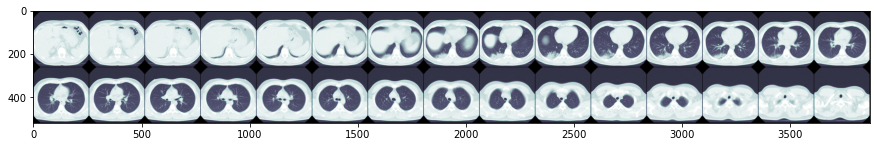

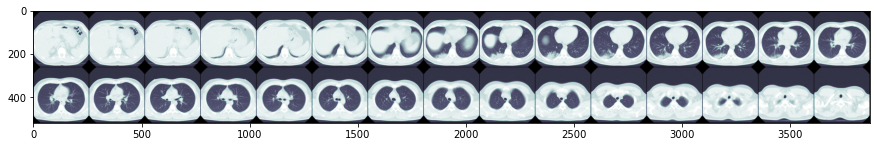

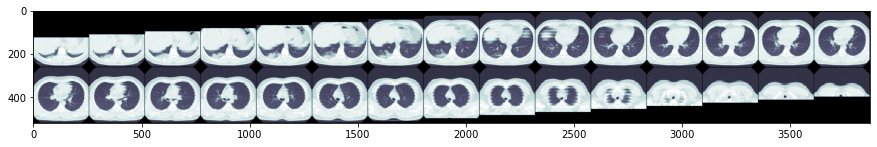

In [ ]:
#original = original.resize_3d((10, 100, 100))
tmp1 = RandomRotate3DBy()(original, split_idx = 0)
tmp2 = RandomRotate3DBy(p=1., degrees=(10, 10, 45),  axis=[-1, -2, -3])(original, split_idx = 0)
original.show(nrow = 15)
tmp1.show(nrow = 15)
tmp2.show(nrow =15)

Rotating by 90 (or 180 and 270) degrees should not be done via `RandomRotate3DBy` but by `rotate_90_3d`, as this is approximatly 28 times faster.

## "Dihedral" transformation

As the 3D array can be flipped by three sides, but should only be rotated along the z axis, this is not a complete dihedral group. Still multiple combinations of flipping and rotating should be implemented:

0. original (= flipp ll, roate 180 = same as original image)
1. rotate 90 
2. rotate 180
3. rotate 270
4. flip ll (=flip ap, rotate 180)
5. flip ap
6. flip cc
7. flip cc, rotate 90
8. flip cc, rotate 180
9. flip cc, rotate 270
10. flip ll, rotate 90
11. flipp ll, rotate 270
12. flip ap, rotate 90
13. flip ap rotate 270
14. flip cc, flip ll, rotate 90
15. flip cc, flipp ll, rotate 270
16. flip cc, flip ap, rotate 90
17. flip cc, flip ap rotate 270

I am not sure if this is complete...

In [ ]:
# export

@patch
def dihedral3d(x:(TensorDicom3D,TensorMask3D), k):
    "apply dihedral transforamtions to the 3D Dicom Tensor"
    if k in [6,7,8,9,14,15,16,17]: x = x.flip(-3)
    if k in [4,10,11,14,15]: x = x.flip(-1)
    if k in [5,12,13,16,17]: x = x.flip(-2)
    if k in [1,7,10,12,14,16]: 
        if x.ndim == 3: x = x.transpose(1, 2)
        else: x = x.transpose(2,3)
    if k in [2,8]: x = x.flip(-1).flip(-2)
    if k in [3,11,13,15,17]: 
        if x.ndim == 3: x = x.transpose(1, 2).flip(-1)
        else: x = x.transpose(2,3).flip(-1)
    return x

class RandomDihedral3D(RandTransform):
    "randomly flip and rotate the 3D Dicom volume with a probability of `p`"
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.k = random.randint(0,17)
    
    def encodes(self, x:(TensorDicom3D,TensorMask3D)): 
        return x.dihedral3d(self.k)

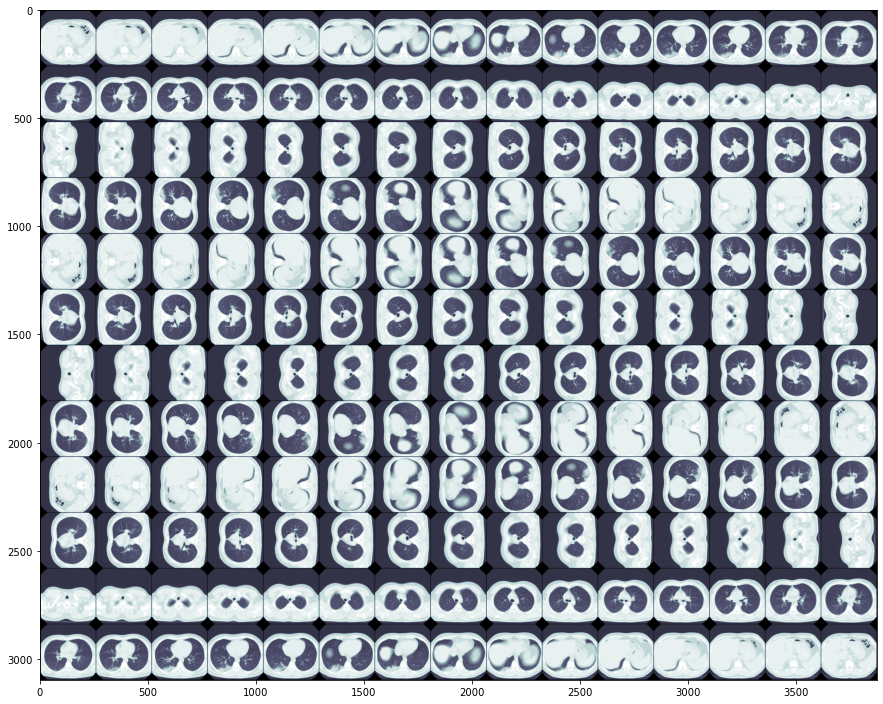

In [ ]:
dihedral = RandomDihedral3D()
torch.stack((original, dihedral(original, split_idx = 0), dihedral(original, split_idx = 0), 
                 dihedral(original, split_idx = 0),dihedral(original, split_idx = 0), 
                 dihedral(original, split_idx = 0))).show(nrow=15)

## Random Crop

A reasonable approach for 3D medical images would be a presizing to uniform but to large volume and subsequent random cropping to the target dimension. As most areas of interest are located centrally in the image/volume some cropping can always be applied.  
Also random cropping should be applied after any rotation, that is not in 90/180/270 degrees, so that empty margins are cropped.

In [ ]:
# export

@patch
def crop_3d(t: (TensorDicom3D, TensorMask3D), crop_by: (int, float), perc_crop = False):
    "Similar to function `crop_3d_tensor`, but no checking for margin formats is done, as they were correctly passed to this function by RandomCrop3D.encodes"    
    typ = type(t)
    dev = t.device
    if t.ndim not in (3,4): raise TypeError('Tensor of size 3 or 4 expected, but got Tensor of size {} with shape {}'.format(t.ndim, t.shape))
    if t.ndim == 3: 
        x, y, z = t.shape
    else: 
        _, x, y, z = t.shape
    x1,x2,y1,y2,z1,z2 = crop_by
    
    if perc_crop: 
        if not all(isinstance(i, float) for i in [x1,x2,y1,y2,z1,z2]): raise ValueError('perc_crop should be a float value between 0 and 0.5')
        x1,x2,y1,y2,z1,z2 = int(x1*x),int(x2*x),int(y1*y),int(y2*y),int(z1*z),int(z2*z)
    
    if t.ndim == 3: 
        return retain_type(t[x1:x-x2, y1:y-y2, z1:z-z2].to(dev), typ = typ)    
    else: 
        return t[:,x1:x-x2, y1:y-y2, z1:z-z2].to(dev)

def _get_margins(crop_by):
    cropx, cropy, cropz = crop_by
    try: x1,x2 = cropx
    except: x1,x2 = cropx,cropx
    try: y1,y2 = cropy
    except: y1,y2 = cropy,cropy
    try: z1,z2 = cropz
    except: z1,z2 = cropz,cropz
    return (x1,x2,y1,y2,z1,z2)

def _add_to_margin(add):
    if type(add) is int: return random.randint(-add,add) 
    if type(add) is float: return random.uniform(-add, add)
        
        
class RandomCrop3D(RandTransform):
    '''
    Randomly crop the 3D volume with a probability of `p`
    The x axis is the "slice" axis, where no cropping should be done by default
    
    Args
        crop_by: number of pixels or pecantage of pixel to be removed at each side. E.g. if (0, 5, 5), 0 pixel in the x axis, but 10 pixels in eacht y and z axis will be cropped (5 each side)
        rand_crop_xyz: range in which the cropping window is allowed to vary.
        perc_crop: if true, no absolute but relative number of pixels are cropped
    '''
    split_idx, p = None, 1
    def __init__(self, crop_by, rand_crop_xyz, perc_crop=False, p=1, **kwargs): 
        super().__init__(p=p,**kwargs)
        self.p = p
        self.crop_by = crop_by
        self.perc_crop = perc_crop
        self.crop_by_x, self.crop_by_y, self.crop_by_z = rand_crop_xyz
        
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx) 
    
        if type(self.crop_by) is tuple and len(self.crop_by) == 3:
            x1,x2,y1,y2,z1,z2 = _get_margins(self.crop_by)             
                    
            self.x_add = _add_to_margin(self.crop_by_x) 
            self.y_add = _add_to_margin(self.crop_by_y) 
            self.z_add = _add_to_margin(self.crop_by_z) 

            self.margins = (x1+self.x_add, x2-self.x_add,
                                y1+self.y_add, y2-self.y_add,
                                z1+self.z_add, z2-self.z_add)

        else:
            raise ValueError('"final_margins" must be a tuple with length 3')

        if any(self.margins) < 0: raise ValueError('cannot crop to a negative dimension')
               
    def encodes(self, x:(TensorDicom3D,TensorMask3D)): 
        return x.crop_3d(crop_by = self.margins, perc_crop = self.perc_crop)

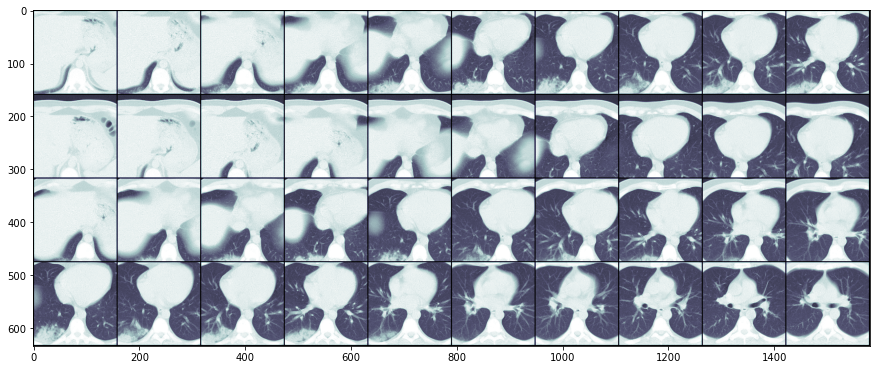

In [ ]:
Crop = RandomCrop3D((10,50,50), (10,20,20), False)

torch.stack((Crop(original, split_idx = 0), Crop(original, split_idx = 0), 
             Crop(original, split_idx = 0), Crop(original, split_idx = 0))).show(nrow = 10)
im = Crop(original).resize_3d((10, 100, 100))

In [ ]:
# export
class ResizeCrop3D(RandTransform):
    split_idx,order = None, 1
    
    "Resize and crop a 3D tensor"
    
    def __init__(self, crop_by, resize_to, perc_crop=False, p=1, **kwargs): 
        resize_to = _process_sz_3d(resize_to)
        crop_by = crop_by
        perc_crop = perc_crop
        store_attr()
        super().__init__(p=p,**kwargs)

    def encodes(self, x:(TensorDicom3D,TensorMask3D)): 
        if type(self.crop_by) is tuple and len(self.crop_by) == 3:
            self.margins =  _get_margins(self.crop_by) 

        else: raise ValueError('"crop_by" must be a tuple with length 3 in the form ox (x,y,z) or ((x1,x2),(y1,y2),(z1,z2))')
        if any(self.margins) < 0: raise ValueError('cannot crop to a negative dimension')
        return x.crop_3d(crop_by = self.margins, perc_crop = self.perc_crop).resize_3d(self.resize_to)


### Mask Ereasing

Sometimes, the images are in an uniform format and the area of interes can be expected in a certain image region. A mask, which covers the areas not of interst can help to futher reduce the image volume


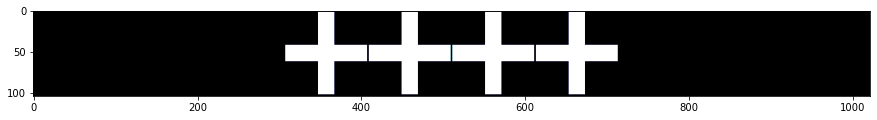

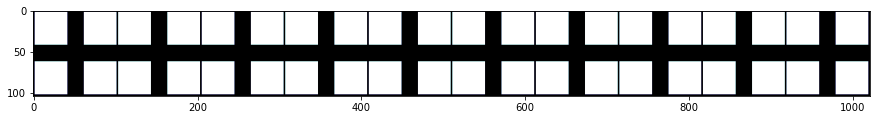

In [ ]:
crop_mask = TensorMask3D(torch.ones(4, 100, 20)).pad_to((10, 100, 100))
crop_mask = crop_mask + crop_mask.rotate_90_3d()
crop_mask = torch.where(crop_mask == 0, 0, 1)

crop_mask2 = TensorMask3D(torch.ones(10, 100, 20)).pad_to((10, 100, 100))
crop_mask2 = crop_mask2 + crop_mask2.rotate_90_3d()
crop_mask2 = torch.where(crop_mask2 == 0, 1, 0)

crop_mask.show()
crop_mask2.show()

In [ ]:
# export
class MaskErease(DisplayedTransform):
    "ereases image areas in dependence of a mask. Strips black spaces afterwards"
    def __init__(self, mask, pad=None,p= 1.):
        if mask.min() != 0 or mask.max() != 1 or len(mask.unique()) != 2:
            raise ValueError('Mask should be a TensorMask3D with only 0 and 1')
        store_attr()

    def encodes(self, x:(TensorDicom3D,TensorMask3D)):
        self.mask = self.mask.to(x.device)
        stripped = (x * self.mask).strip()
        max_sz = np.max((stripped.size(-1), stripped.size(-2)))
        if self.pad is None: return stripped.pad_to((stripped.size(-3), max_sz, max_sz))
        else: return stripped.pad_to(self.pad)

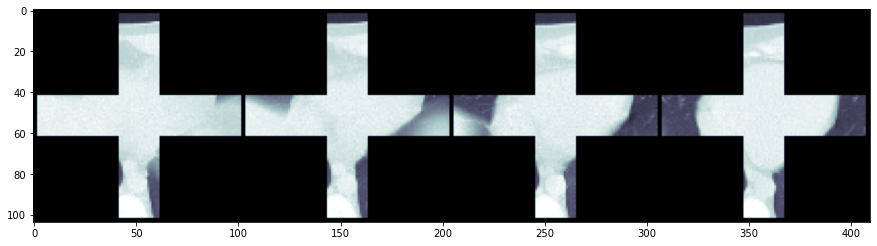

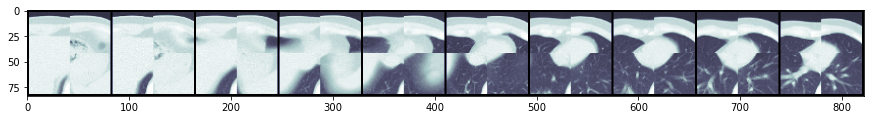

In [ ]:
MaskErease(mask = crop_mask)(im).show()
MaskErease(mask = crop_mask2)(im).show()

## Random Change of Perspective 

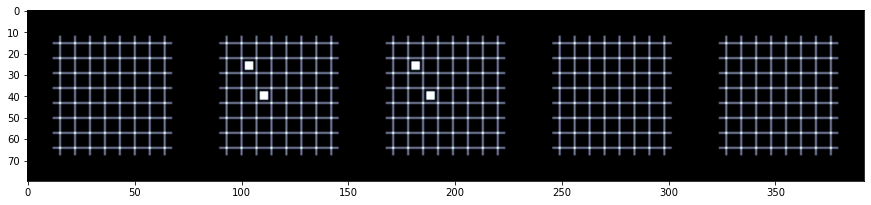

In [ ]:
im2 = TensorDicom3D.create('../data/example_grid.nii.gz')
im2 = im2.unsqueeze(0)
im2.show()

In [ ]:
# export
class RandomPerspective3D(RandTransform):
    def __init__(self, input_size, p=0.5, distortion_scale = 0.25): 
        super().__init__(p=p)
        store_attr()
        
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        tmp = torchvision.transforms.RandomPerspective(self.distortion_scale)
        self.start, self.end = tmp.get_params(self.input_size, self.input_size, self.distortion_scale)
        
    def encodes(self, x:TensorDicom3D): 
        return  _F.perspective(x, self.start, self.end)
    
    def encodes(self, x:TensorMask3D): 
        return   _F.perspective(x, self.start, self.end)

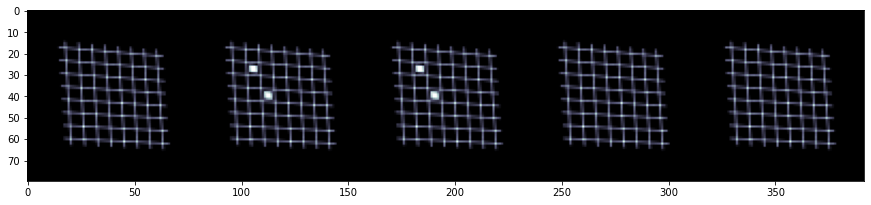

In [ ]:
RandomPerspective3D(im.size(-1), p = 1.)(im2, split_idx=0).show()

## Further Perspective Distortions

Augmentations based on Grid resampling. Not as many possibilities as `RandomPerspective`, but does allow to fill empty areas with mirrored image and not just 0 padding. 

## Perspective warping 

Light wrapping can mimic artifacts in MRI images or breathing artifacts in CT images

In [ ]:
# export
def warp_3d(h,w,magnitude_h, magnitude_w):
    warp_h = int(h*magnitude_h)
    warp_w = int(w*magnitude_w)
    warp_h1 = round(h//2 + warp_h) 
    warp_h2 = h - warp_h1     
    warp_w1 = round(w //2 + warp_w) 
    warp_w2 = w - warp_w1
    x = torch.cat(
        (torch.linspace(-1, 0, warp_h1), 
        torch.linspace(0, 1, warp_h2+1)[1:]))
    y = torch.cat(
        (torch.linspace(-1, 0, warp_w1), 
        torch.linspace(0, 1, warp_w2+1)[1:]))
    return torch.meshgrid((x,y)) 


@patch
def grid_tfms(t: (TensorDicom3D,TensorMask3D), func, mode): 
    "wrapper for grid tfms"
    typ = type(t)
    dev = t.device
    if t.ndim < 4: t = t.unsqueeze(0)
    _, d,h,w = t.shape 
    
    meshx, meshy = func(h,w)
    grid = torch.stack((meshx, meshy),2)
    grid = torch.stack((grid.to(dev),)*t.shape[0],0) 
    out = F.grid_sample(t, grid, align_corners=True, mode = mode, padding_mode='reflection') 
    out = out.permute(0,1,3,2).contiguous() 
    if typ == TensorMask3D: out=out.round()
    return retain_type(out, typ = typ)
    
class RandomWarp3D(RandTransform):
    def __init__(self, p=0.5, max_magnitude = 0.25): 
        super().__init__(p=p)
        self.max_magnitude = max_magnitude*random.choice([-1,1])
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.magnitude_w= random.random()*self.max_magnitude 
        self.magnitude_h = random.random()*self.max_magnitude 
        
    def encodes(self, x:(TensorDicom3D)): 
        return x.grid_tfms(func=partial(warp_3d, magnitude_h = self.magnitude_h, magnitude_w = self.magnitude_w), mode='bilinear') 
    
    def encodes(self, x:TensorMask3D): 
        return x.grid_tfms(func=partial(warp_3d, magnitude_h = self.magnitude_h, magnitude_w = self.magnitude_w), mode='nearest') 

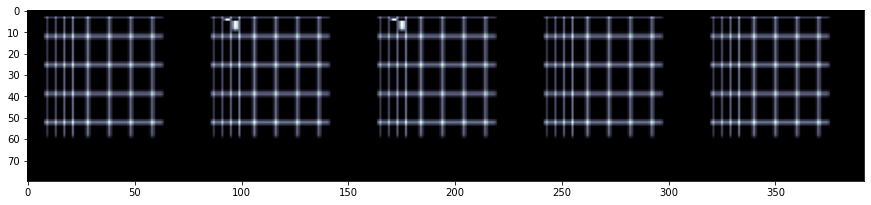

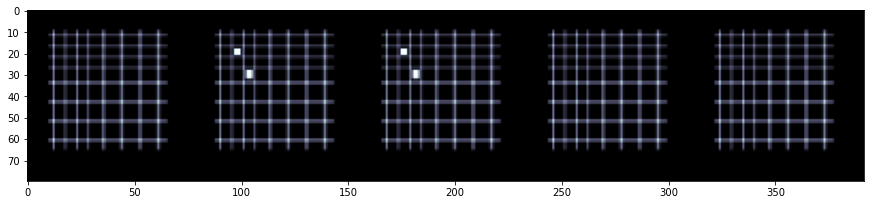

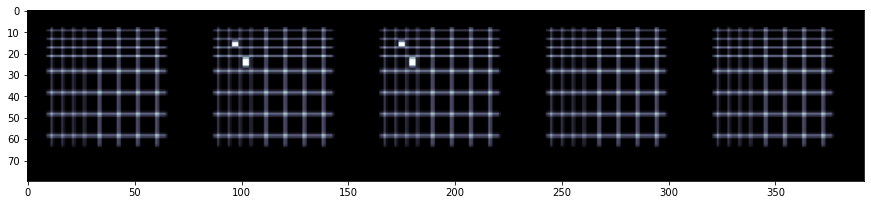

In [ ]:
RandomWarp3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomWarp3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomWarp3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()

### Sheering

In [ ]:
# export
def sheer_3d(h,w, magnitude_h, magnitude_w): 
    "applies a random sheer to the tenspr"
    x = torch.linspace(-1, 1, h)
    y = torch.linspace(-1, 1, w) 
    magnitude_h = torch.linspace(-magnitude_h, magnitude_h, h)
    magnitude_w = torch.linspace(-magnitude_w, magnitude_w, w)
    meshx, meshy = torch.meshgrid((x,y)) #
    return meshx+magnitude_h, meshy+magnitude_w
    
class RandomSheer3D(RandomWarp3D):        
    def encodes(self, x:(TensorDicom3D)): 
        return x.grid_tfms(func=partial(sheer_3d, magnitude_h = self.magnitude_h, magnitude_w = self.magnitude_w), mode='bilinear') 
    
    def encodes(self, x:TensorMask3D): 
        return x.grid_tfms(func=partial(sheer_3d, magnitude_h = self.magnitude_h, magnitude_w = self.magnitude_w), mode='nearest') 

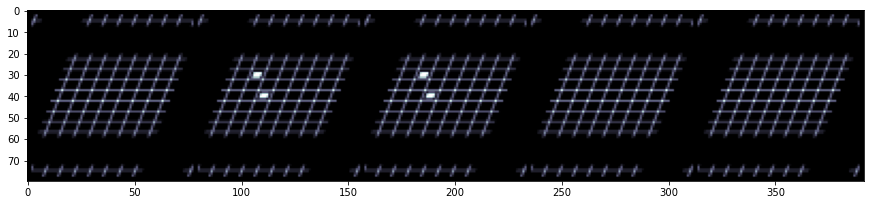

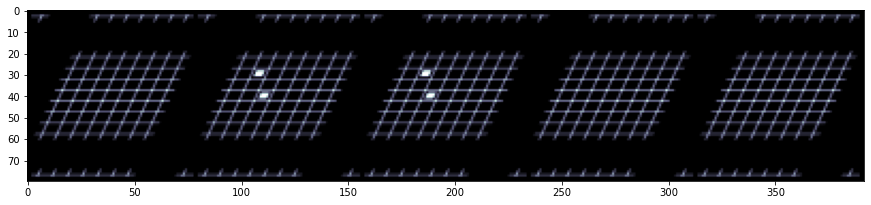

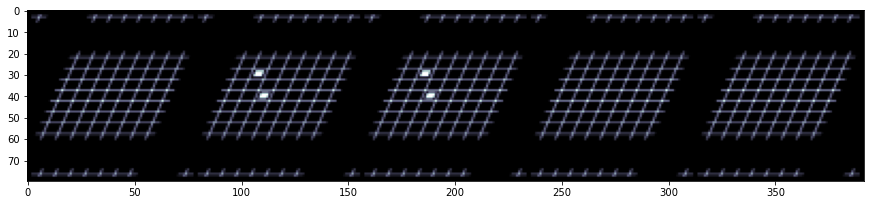

In [ ]:
RandomSheer3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomSheer3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomSheer3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()

### Trapezoid

In [ ]:
# export
def trapezoid_3d(h,w, magnitude): 
    "applies a random sheer to the tenspr"
    x = torch.linspace(-1, 1, h)
    y = torch.linspace(-1, 1, w) 
    magnitude_h = torch.linspace(1-abs(magnitude),1, h)
    meshx, meshy = torch.meshgrid((x,y)) 
    meshx = meshx/magnitude_h if magnitude < 0 else meshx*magnitude_h
    return meshx, meshy


class RandomTrapezoid3D(RandomWarp3D):        
    def encodes(self, x:(TensorDicom3D)): 
        return x.grid_tfms(func=partial(trapezoid_3d, magnitude = self.magnitude_h), mode='bilinear') 
    def encodes(self, x:TensorMask3D): 
        return x.grid_tfms(func=partial(trapezoid_3d, magnitude = self.magnitude_h), mode='nearest') 

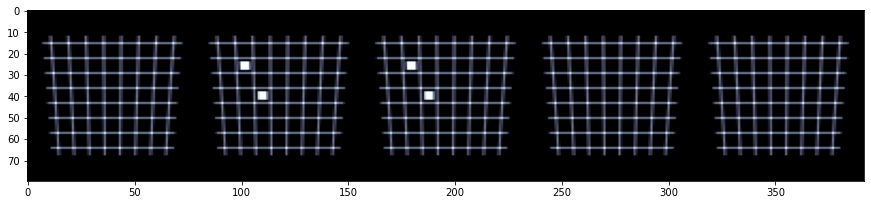

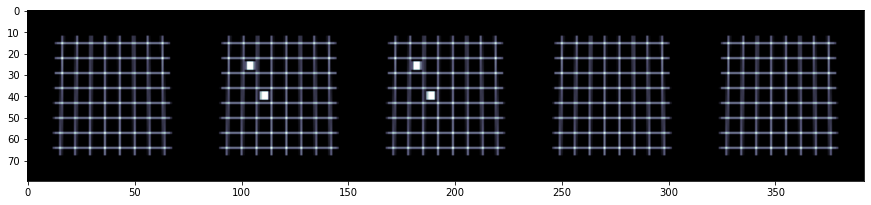

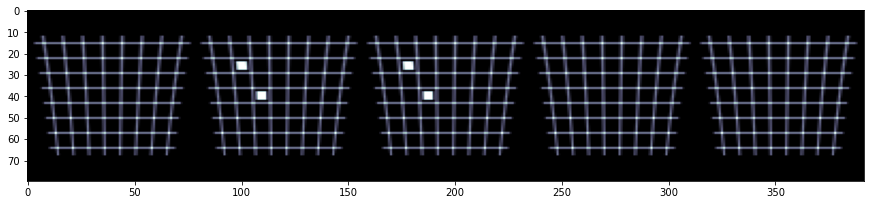

In [ ]:
RandomTrapezoid3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomTrapezoid3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()
RandomTrapezoid3D(p=1, max_magnitude=0.5)(im2, split_idx = 0).show()

## Random Gaussian noise

Older scanners with lower field strength (MRI), fewer slices (CT), older algorithms can be more noise. So adding some random noise to the data, could improve model performance. 

In [ ]:
# export
@patch
def gaussian_noise(t:(TensorDicom3D), std):
    shape = torch.randn(t.shape).to(t.device)
    return t + (std**0.5)*shape*t
    
class RandomNoise3D(RandTransform):
    def __init__(self, p=0.5, std_range=[0.01, 0.1]): 
        super().__init__(p=p)
        self.lwr_std = np.min(std_range)
        self.upr_std = np.max(std_range)

    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.std = random.choice(np.arange(self.lwr_std, 
                                           self.upr_std, 
                                           self.lwr_std))        
    def encodes(self, x:(TensorDicom3D)): 
        return x.gaussian_noise(self.std)
    
    def encodes(self, x:TensorMask3D): return x

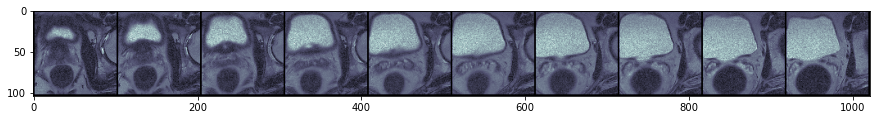

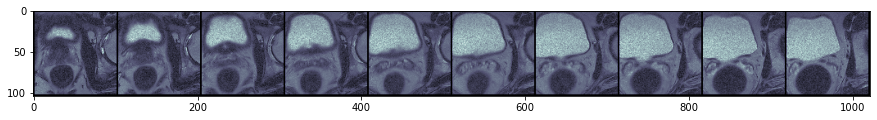

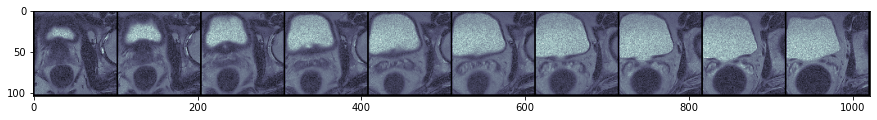

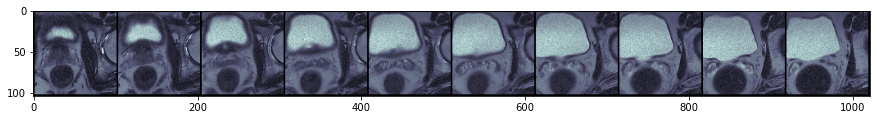

In [ ]:
from faimed3d.preprocess import mean_scale
Noise= RandomNoise3D(p=1)
RandomNoise3D(p=1)(im.mean_scale(), split_idx=0).show()
RandomNoise3D(p=1)(im.mean_scale(), split_idx=0).show()
RandomNoise3D(p=1)(im.mean_scale(), split_idx=0).show()
RandomNoise3D(p=1)(im.mean_scale(), split_idx=0).show()

## Gaussian Blur

In [ ]:
#export
class RandomBlur3D(RandTransform):
    def __init__(self, p=0.5, kernel_size_range=[5, 11], sigma=0.5): 
        super().__init__(p=p)
        store_attr()
    
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        sizes = range(self.kernel_size_range[0], 
                      self.kernel_size_range[1], 
                      2)
        self.kernel = random.choices(sizes, k = 2)
        
    def encodes(self, x:(TensorDicom3D)): 
        return _F.gaussian_blur(x, self.kernel, self.sigma)
    
    def encodes(self, x:TensorMask3D): return x

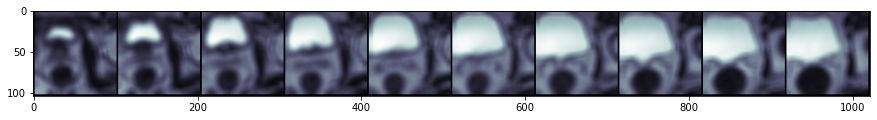

In [ ]:
RandomBlur3D(p=1., sigma = 10)(im, split_idx=0).show()

## Lightning transforms

Simple brightness and contrast controlls can be dona via a linear function: 

    x = alpha * x_i + beta  

here x_i is the respective pixel, alpha allows simple contrast control, beta allows simple brightness control.

In [ ]:
# export

@patch
def rescale(t: TensorDicom3D, new_min = 0, new_max = 1):
    return (new_max - new_min)/(t.max()-t.min()) *(t - t.max()) + t.max()    
    
@patch
def adjust_brightness(x:TensorDicom3D, beta):
    return torch.clamp(x + beta, x.min(), x.max())


class RandomBrightness3D(RandTransform):
    def __init__(self, p=0.5, beta_range=[-0.3, 0.3]): 
        super().__init__(p=p)
        self.lwr_beta = np.min(beta_range)
        self.upr_beta = np.max(beta_range)

    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.beta = random.choice(np.arange(self.lwr_beta, 
                                           self.upr_beta, 
                                           25))
    def encodes(self, x:TensorDicom3D): 
        return x.adjust_brightness(self.beta)

    def encodes(self, x:TensorMask3D): return x
    

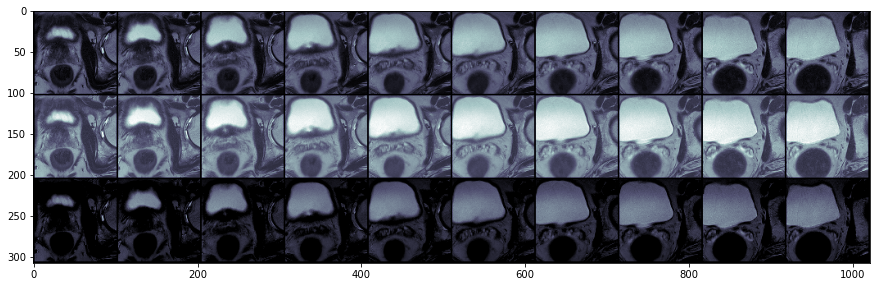

In [ ]:
torch.stack((im.mean_scale(), 
             RandomBrightness3D(p=1., beta_range=[0.9, 1])(im.mean_scale(), split_idx = 0), 
             RandomBrightness3D(p=1., beta_range=[-0.9, -1])(im.mean_scale(), split_idx = 0))).show()

## Contrast

In [ ]:
# export
@patch
def adjust_contrast(x:TensorDicom3D, alpha):
    x2 = x*alpha
    min = x2.min() + abs(x2.min() - x.min())
    return torch.clamp(x2, min, x.max())    

class RandomContrast3D(RandTransform):
    def __init__(self, p=0.6, alpha_range=[0.7, 2.]): 
        super().__init__(p=p)
        self.lwr_alpha = np.min(alpha_range)
        self.upr_alpha = np.max(alpha_range)
        
    def before_call(self, b, split_idx):
        super().before_call(b, split_idx)
        self.alpha = random.choice(np.arange(self.lwr_alpha, 
                                            self.upr_alpha, 
                                            25))
        
    def encodes(self, x:TensorDicom3D): 
        return x.adjust_contrast(self.alpha)
    
    def encodes(self, x:TensorMask3D): return x


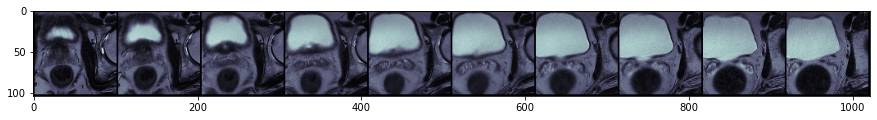

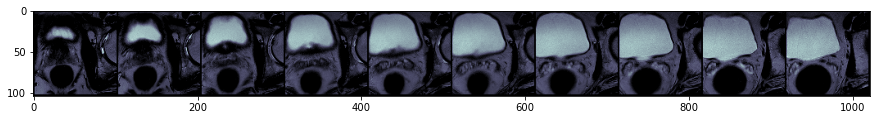

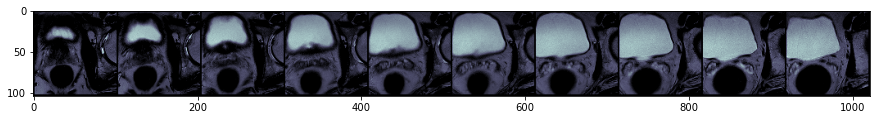

In [ ]:
im.mean_scale().show()
RandomContrast3D(p=1.)(im.mean_scale(), split_idx = 0).show()
RandomContrast3D(p=1.)(im.mean_scale(), split_idx = 0).show()

## Elastic transforms
https://theaisummer.com/medical-image-processing/#8-intensity-normalization-in-medical-images


In [ ]:

def elastic_transform_3d(image, labels=None, alpha=4, sigma=35, bg_val=0.1):
    """
    Elastic deformation of images as described in
    Simard, Steinkraus and Platt, "Best Practices for
    Convolutional Neural Networks applied to Visual
    Document Analysis", in
    Proc. of the International Conference on Document Analysis and
    Recognition, 2003. 

    Modified from:
    https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    https://github.com/fcalvet/image_tools/blob/master/image_augmentation.py#L62

    Modified to take 3D inputs
    Deforms both the image and corresponding label file
    image linear/trilinear interpolated

    Label volumes nearest neighbour interpolated
    """
    assert image.ndim == 3
    shape = image.shape
    dtype = image.dtype

    # Define coordinate system
    coords = np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2])

    # Initialize interpolators
    im_intrps = RegularGridInterpolator(coords, image,
                                                method="linear",
                                                bounds_error=False,
                                                fill_value=bg_val)

    # Get random elastic deformations
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                         mode="constant", cval=0.) * alpha
    dz = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma,
                        mode="constant", cval=0.) * alpha

    # Define sample points
    x, y, z = np.mgrid[0:shape[0], 0:shape[1], 0:shape[2]]
    indices = np.reshape(x + dx, (-1, 1)), \
             np.reshape(y + dy, (-1, 1)), \
             np.reshape(z + dz, (-1, 1))

    # Interpolate 3D image image
    image = np.empty(shape=image.shape, dtype=dtype)
    image = im_intrps(indices).reshape(shape)

    # Interpolate labels
    if labels is not None:
        lab_intrp = RegularGridInterpolator(coords, labels,
                                           method="nearest",
                                           bounds_error=False,
                                           fill_value=0)

        labels = lab_intrp(indices).reshape(shape).astype(labels.dtype)
        return image, labels

    return image


## Putting it all together

A good workflow would be to apply random crop to all images after one transformation. For this, the images should be presized to a size, just some pixels larger then desired, then transformed and then cropped to the final size. Using this approach empty space, which e.g. appears after `RandomRotate3DBy` will be cropped and not influence the accuracy of the model. One only has to be careful, that the region of interest, e.g. the prostate, will be in every cropped image. 

In [ ]:
Crop = RandomCrop3D((2,10,10), (1,2,2))

tfms = [RandomBrightness3D(), RandomContrast3D(), RandomWarp3D(), RandomDihedral3D(), RandomNoise3D(), RandomRotate3DBy()]
tfms = [Pipeline([RandomBrightness3D(p=1.), Crop], split_idx = 0), 
        Pipeline([RandomContrast3D(p=1.), Crop], split_idx = 0), 
        Pipeline([RandomWarp3D(p=1.), Crop], split_idx = 0), 
        Pipeline([RandomDihedral3D(p=1.), Crop], split_idx = 0), 
        Pipeline([RandomNoise3D(p=1.), Crop], split_idx = 0), 
        Pipeline([RandomRotate3DBy(p=1.), Crop], split_idx = 0)]

In [ ]:
comp = setup_aug_tfms(tfms)
comp

[Pipeline: RandomBrightness3D -- {'p': 1.0} -> RandomCrop3D -- {'p': 1},
 Pipeline: RandomContrast3D -- {'p': 1.0} -> RandomCrop3D -- {'p': 1},
 Pipeline: RandomWarp3D -- {'p': 1.0} -> RandomCrop3D -- {'p': 1},
 Pipeline: RandomDihedral3D -- {'p': 1.0} -> RandomCrop3D -- {'p': 1},
 Pipeline: RandomNoise3D -- {'p': 1.0} -> RandomCrop3D -- {'p': 1},
 Pipeline: RandomRotate3DBy -- {'p': 1.0, 'degrees': (2, 2, 30), 'axis': [-1, -2, -3]} -> RandomCrop3D -- {'p': 1}]

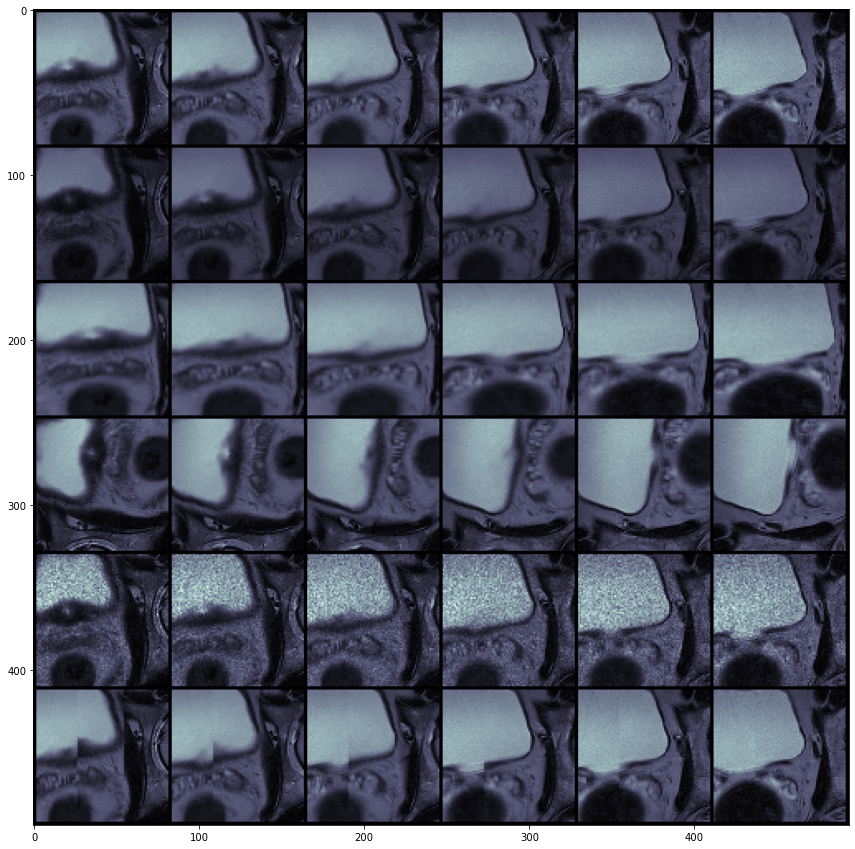

In [ ]:
ims = [t(im).squeeze() for t in tfms]
torch.stack(ims).show(nrow = 6)

## Creating a pseudo color channel

Pytorch expects the images in the following format: 

B * C * D * H * W

Here:  
- B = Batch dimension
- C = Number of Channels (e.g. color)
- D = Depth of the image (= number of slices)
- H = Height of the image
- W = Width of the image

In [ ]:
#deprecated

@patch
def make_pseudo_color(t: (TensorDicom3D, TensorMask3D)): 
    '''
    The 3D CNN still expects color images, so a pseudo color image needs to be created as long as I don't adapt the 3D CNN
    '''
    if t.ndim == 3:
        return t.unsqueeze(0).float()  
    elif t.ndim == 4:
        return t.unsqueeze(1).float()
    else: 
        return t  

class PseudoColor(RandTransform):
    split_idx, p = None, 1
    
    def __init__(self, p=1): 
        super().__init__(p=p)

    def __call__(self, b, split_idx=None, **kwargs):
        "change in __call__ to enforce, that the Transform is always applied on every dataset. "
        return super().__call__(b, split_idx=split_idx, **kwargs) 
    
    def encodes(self, x:(TensorDicom3D, TensorMask3D)): 
        return x.make_pseudo_color()

In [ ]:
MakeColor = PseudoColor()
im.shape, MakeColor(im, split_idx = 0).shape

((10, 100, 100), (1, 10, 100, 100))

In [ ]:
# export
def _set_p_tfms(p, p_all):
    return p_all if p is None else p

In [ ]:
# export
def aug_transforms_3d(p_all = .1, 
                      warp = True, p_warp = None, 
                      sheer = True, p_sheer = None, 
                      trapezoid = True, p_trapezoid = None, 
                      dihedral = True, p_dihedral = None, 
                      brightness = True, p_brightness = None, 
                      contrast = True, p_contrast = None,
                      noise = True, p_noise = None,
                      rotate_by = True, p_rotate_by = None,
                      flip = True, p_flip = None, 
                      rotate = True, p_rotate = None,
                      blur = True, p_blur = None,
                      crop = True, p_crop = 1):
    tfms = []
    
    if warp: tfms.append(RandomWarp3D(p=_set_p_tfms(p_warp, p_all))) 
    if sheer: tfms.append(RandomSheer3D(p=_set_p_tfms(p_sheer, p_all))) 
    if trapezoid: tfms.append(RandomTrapezoid3D(p=_set_p_tfms(p_trapezoid, p_all))) 
    if dihedral: tfms.append(RandomDihedral3D(p=_set_p_tfms(p_dihedral, p_all))) 
    if brightness: tfms.append(RandomBrightness3D(p=_set_p_tfms(p_brightness, p_all))) 
    if contrast: tfms.append(RandomContrast3D(p=_set_p_tfms(p_contrast, p_all))) 
    if noise: tfms.append(RandomNoise3D(p=_set_p_tfms(p_noise, p_all))) 
    if rotate_by: tfms.append(RandomRotate3DBy(p=_set_p_tfms(p_rotate_by, p_all))) 
    if flip: tfms.append(RandomFlip3D(p=_set_p_tfms(p_flip, p_all))) 
    if rotate: tfms.append(RandomRotate3D(p=_set_p_tfms(p_rotate, p_all))) 
    if blur: tfms.append(RandomBlur3D(p=_set_p_tfms(p_blur, p_all))) 
        
    
    return tfms

(10, 100, 100)


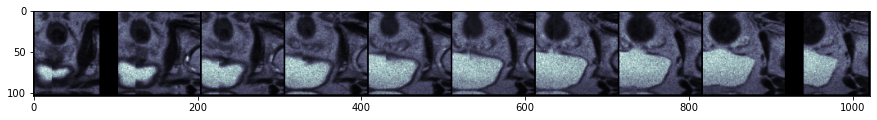

In [ ]:
tmp = Pipeline(aug_transforms_3d(p_all = 1.), split_idx=0)(im)
print(tmp.size())
tmp.show()

## Mask Transformations

Transformations for the mask in segmentation tasks. 
If it is a multilabel segmentation task, the mask needs to be converted into a one hot encoded tensor. 

In [ ]:
# export
@patch
def clamp_to_range(x:TensorMask3D, lwr, upr):
    return torch.clamp(x, lwr, upr)    

class ClampMask3D(RandTransform):
    "Clamps/Clips mask value to a range"
    split_idx = None
    def __init__(self, lwr=0,upr=1,p=1): 
        super().__init__(p=p)
        self.lwr=lwr
        self.upr=upr
        
    def encodes(self, x:TensorMask3D): 
        return x.clamp_to_range(self.lwr, self.upr).to(x.device)

In [ ]:
# export
@patch
def reduce_classes(x:TensorMask3D, classes:(list, tuple)):
    dev = x.device
    x = x.long()
    for c in x.unique():
        if c not in classes:
            x = torch.where(x == c, 0, x)
    for i,c in enumerate(x.unique()):
        x = torch.where(x == c, i, x)
    return x.float().to(dev)

class ReduceClasses(RandTransform):
    "Removes classes from mask"
    def __init__(self, reduce_to,p=1):
        store_attr()
        super().__init__(p=p)

    def encodes(self, x:TensorMask3D):
        return x.reduce_classes(self.reduce_to).to(x.device)

In [ ]:
mask.reduce_classes([2]).unique()

TensorMask3D([0., 1.])

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_transforms.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_layers.ipynb.
Converted 06_learner.ipynb.
Converted 06a_models.alexnet.ipynb.
Converted 06b_models.resnet.ipynb.
Converted 06c_models.densenet.ipynb.
Converted 06d_models.unet.ipynb.
Converted 06e_models.deeplabv3.ipynb.
Converted 06f_models.losses.ipynb.
Converted 07_callback.ipynb.
Converted 08_parallel.unet.ipynb.
Converted 98_widgets.ipynb.
Converted 99_tools.ipynb.
Converted 99_widgets.cam.ipynb.
Converted index.ipynb.
Converted tutorial_mri-normalization.ipynb.
